# Machine Translation Example

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import shap

model_id = "Helsinki-NLP/opus-mt-en-es"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

text = "Transformers have rapidly become the model of choice for NLP problems, replacing older recurrent neural network models"

# build an explainer by passing the model and tokenizer 
explainer = shap.Explainer(model, tokenizer)

# explainers are callable
shap_values = explainer([text], fixed_context=1)

# visualize the result 
shap.plots.text(shap_values)

/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Sentiment Analysis on IMDB dataset 

## load dependencies

In [3]:
import datasets
# import numpy as np 
import transformers 
import shap 

## load dataset

In [4]:
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit the model 
short_data = [v[:500] for v in dataset["text"][:20]]

## load and run the pipeline

In [5]:
classifier = transformers.pipeline("sentiment-analysis", return_all_scores=True)
classifier(short_data[:2])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'NEGATIVE', 'score': 0.07582215219736099},
  {'label': 'POSITIVE', 'score': 0.9241778254508972}],
 [{'label': 'NEGATIVE', 'score': 0.01834249496459961},
  {'label': 'POSITIVE', 'score': 0.9816575050354004}]]

## explain the pipeline

In [6]:
explainer = shap.Explainer(classifier)

shap_values = explainer(short_data[:2])

/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:57, 28.59s/it]               


In [7]:
type(shap_values)

shap._explanation.Explanation

In [8]:
shap_values.shape # num_batch, seq_len, num_labels

(2, None, 2)

In [9]:
shap.plots.text(shap_values[:, :, "POSITIVE"])

In [11]:
shap.plots.text(shap_values)


## Wrap the pipeline manually


`rescale_to_logits`: applying `scipy.special.logit` if set to True

`output[i, self.label2id[obj["label"]]] = scipy.special.logit(obj["score"]) if self.rescale_to_logits else obj["score"]`


In [12]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=False) 
pmodel(short_data[:2])

array([[0.07582215, 0.92417783],
       [0.01834249, 0.98165751]])

In [13]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
pmodel(short_data[:2])

array([[-2.50051403,  2.50051371],
       [-3.98002198,  3.98002198]])

## Pass a tokenizer as the masker object

In [16]:
explainer2 = shap.Explainer(pmodel, classifier.tokenizer)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:04, 32.36s/it]               


## Build a text masker explicitly

In [17]:
masker = shap.maskers.Text(classifier.tokenizer)
explainer2 = shap.Explainer(pmodel, masker)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:06, 33.18s/it]               


## Explore how the text masker workds 

In [18]:
masker.shape("I like this movie.")

(1, 7)

In [19]:
model_args = masker(
    np.array([True, True, True, True, True, True, True]), "I like this movie."
)
model_args

(array(['I like this movie.'], dtype='<U18'),)

In [22]:
pmodel(*model_args)


array([[-8.9078035 ,  8.90786191]])

In [23]:
model_args = masker(
    np.array([True, True, False, False, True, True, True]), "I like this movie."
)
model_args

(array(['I [MASK] [MASK]movie.'], dtype='<U21'),)

In [24]:
pmodel(*model_args)


array([[-3.72091574,  3.72091542]])

In [25]:
masker2 = shap.maskers.Text(
    classifier.tokenizer, mask_token="...", collapse_mask_token=True
)

In [26]:
model_args2 = masker2(
    np.array([True, True, False, False, True, True, True]), "I like this movie."
)
model_args2

(array(['I ...movie.'], dtype='<U11'),)

In [27]:
pmodel(*model_args2)


array([[-3.20817806,  3.20817796]])

## Plot summary statistics and bar charts


In [29]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:56, 28.41s/it]


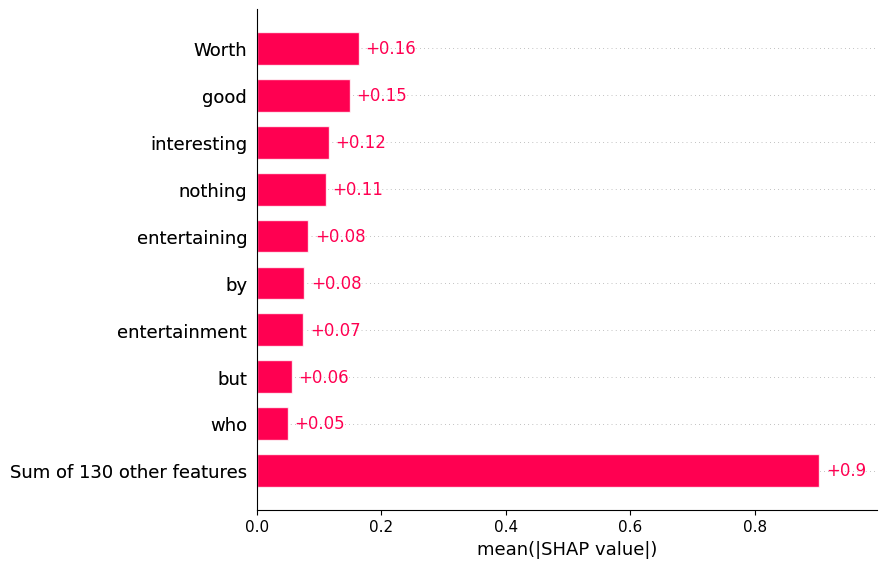

In [36]:
shap.plots.bar(shap_values[:, :, "POSITIVE"])


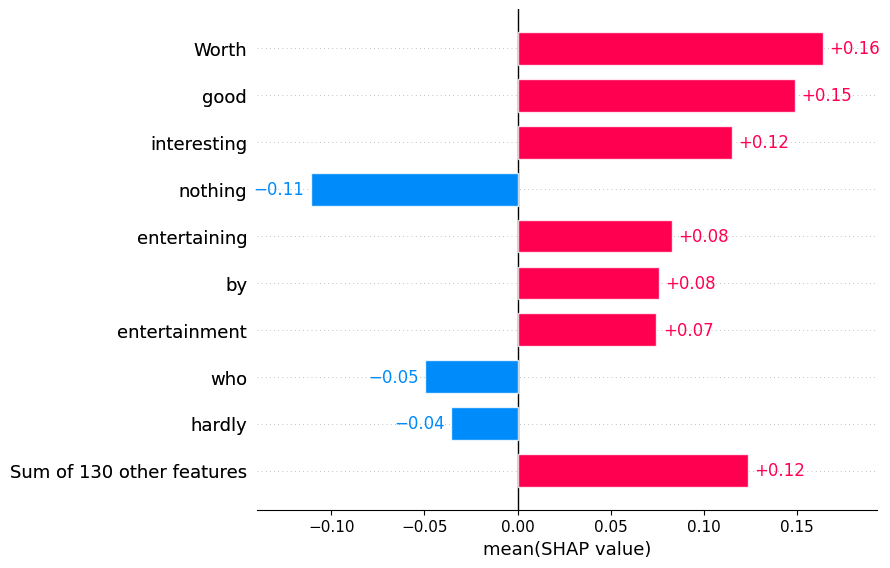

In [34]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0))


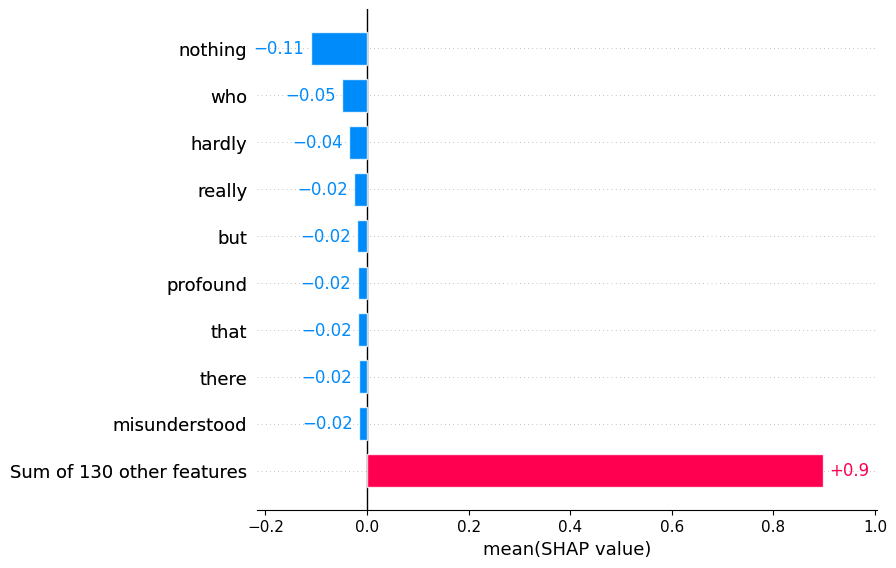

In [33]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0), order=shap.Explanation.argsort)


# References

- [Interpretability Revisited: LIME and SHAP in prose and code](https://colab.research.google.com/drive/1pjPzsw_uZew-Zcz646JTkRDhF2GkPk0N?usp=sharing)